In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.702118  1.150870  0.214180 -0.092335 -0.269355  0.380202  0.549936   
  1  -0.508342  0.655054  0.208384  0.198515  1.041633  1.012090  0.706534   
  2   0.152562  1.015941  0.544495  0.024672 -0.710292 -0.529212  0.671373   
  3  -0.556582 -1.153333  0.223322  0.961042 -0.541617  1.267957  0.623289   
  4  -0.472391 -0.526008 -0.085592  0.890293 -0.431095  0.364151  0.494273   
  5   0.401323  0.280543  0.626266  0.203916  0.144074  0.217061 -0.195532   
  6  -0.145073 -1.228130  0.225464  0.908868  0.260159 -0.639674 -0.314065   
  7   0.073573  0.522435  0.517010  0.201353  0.486178  0.130210  1.287395   
  8   0.400672 -0.529117 -0.356034 -0.206593 -0.093297 -0.559766  1.232214   
  9   0.508191  0.706486  0.815785  0.227518  0.753779  0.605550  0.877610   
  10 -0.857383 -0.552749  0.144967  1.039673  1.401667  0.614716  0.554095   
  11  0.740684  0.377134 -0.021066  0.450133 -0.196582 -0.479056  0.766751   
  12  0.136427 -0.242648  0.615376  0.523781  0.811411 -0.122524 -0.470666   
  13  0.884250  0.801511 -0.102269 -0.207371 -0.305362  0.093467  0.069207   
  14  1.302006 -0.048930  0.418266  0.749977  0.455916  0.632058 -0.675924   
  15  0.691855  0.200889  0.062909 -0.234579  0.834752  0.467508 -0.037844   
  16  0.274501  0.012639  0.519207  0.799955  0.052965 -0.713776  0.741295   
  17  0.582751 -0.234268 -0.730340 -0.604203 -0.980107 -0.130452 -0.312683   
  18 -0.133407  0.339002  0.703164  0.544974  0.269727 -0.321934  0.684042   
  19  1.010478  1.709847  0.104248  0.435301  0.732942 -0.062907  1.058615   
  20 -0.600338 -0.256206  0.445901 -0.157983  1.240750 -0.506721 -0.055847   
  21  0.914434 -0.049476  0.519187  0.530400  0.197452 -0.354508  0.292984   
  22 -0.075478  0.568899 -0.334808 -0.293132  1.021667 -0.150295  1.617027   
  23 -0.017504 -0.422378  0.189956  0.421542  0.174644 -0.250305  0.311435   
  24  0.328100  0.617589  0.674004  0.685457  0.175162  0.104378  0.260824   
1 0  -0.077441  0.202131 -0.558149 -1.244747 -0.882508 -1.594614  0.454763   
  1  -0.749460 -0.396822 -0.541080 -0.265975 -0.922577 -0.587848 -0.225393   
  2   0.248042  0.132704  0.097248 -0.012509  0.220584 -0.207750 -0.480870   
  3   0.169854 -0.032194 -1.543981 -0.995451  0.111531 -0.163673  0.402424   
  4  -0.936836 -0.087807  0.769584 -0.479804  0.207498 -0.465256 -0.650880   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.340319 -0.685576  0.174151  ... -0.523800 -0.063364  0.073212   
  1   0.444538  0.004699 -0.045488  ... -0.113388 -0.690921 -0.601268   
  2   0.339891  0.353152  1.123119  ... -0.728639  0.015502 -0.075001   
  3   0.377364  0.154938 -0.153163  ...  0.419977 -0.598210 -0.557768   
  4   0.855002  0.771145  0.633857  ...  0.783652 -0.528698 -0.719577   
  5  -0.565198  0.188743 -1.727251  ... -0.103852  0.583961  0.220677   
  6   0.256138  0.482604  0.051867  ... -0.608216 -0.236707  0.663768   
  7   0.142766  0.860765  0.477379  ... -0.469620 -1.025155 -0.081752   
  8   0.360741 -0.576451 -0.050239  ...  0.261087 -0.278999 -0.405890   
  9   0.165097  0.329844 -0.080399  ...  0.235667 -0.624782 -0.392080   
  10  0.555548  0.557281  0.588586  ... -0.730210 -1.464388  0.653805   
  11  1.034999  1.123496  0.138470  ... -0.525713 -0.093356 -0.882535   
  12  0.164004 -0.083516 -0.259301  ... -1.343085 -0.351831  0.614015   
  13 -0.281512  0.686350 -0.102254  ... -0.224468  0.117794  0.182292   
  14  0.061315 -0.717796 -0.659490  ...  0.564185  0.200394  0.505196   
  15  0.372878  0.589498  0.025724  ... -0.317912  0.687939  0.276890   
  16  0.881306  1.193827  0.932227  ... -0.561728 -0.776292 -0.758390   
  17 -0.307211  0.244702  0.330389  ... -1.164472 -1.703115  0.136732   
  18  1.013768  0.228019  0.420482  ... -0.276702 -0.505388 -0.163833   
  19 -0.337892 -0.906632 -0.951152  ...  0.540544 -1.034007 -0.704684   
  20 -0.025612  0.448754 -0.508928  ... -0.590730 -1.445615 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.090811  0.044937  24.274269  3.665963e-130  1.002736  1.178886


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



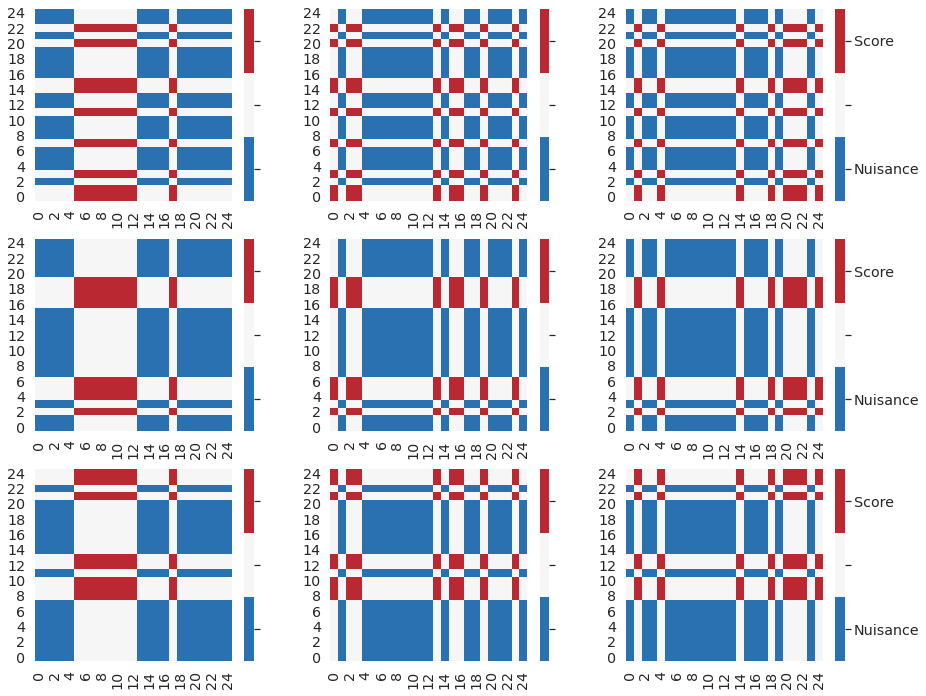

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



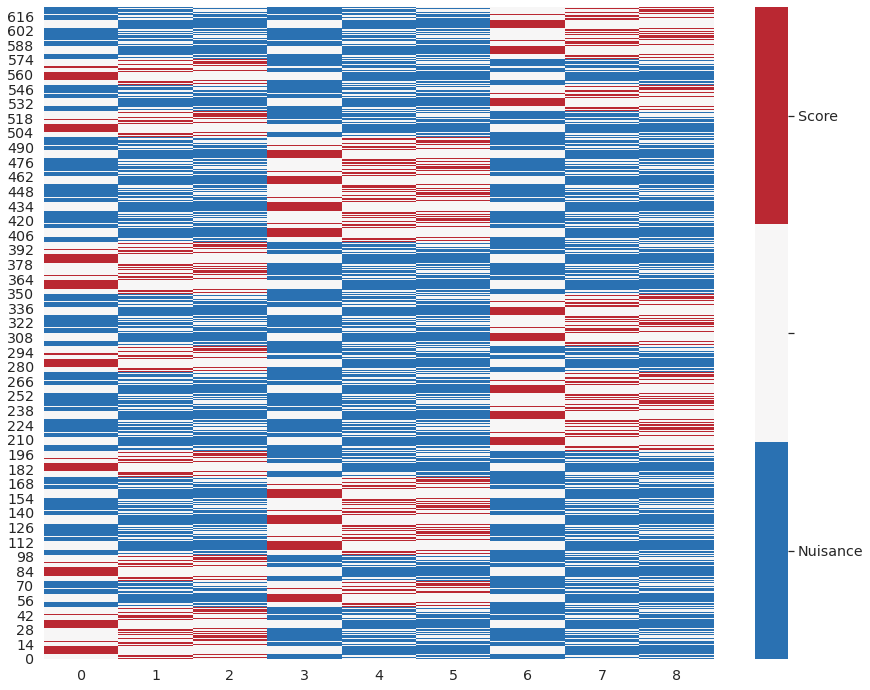

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])